In [15]:
# Import needed modules

# Import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# Import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# Import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [17]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
print('Modules loaded')

Modules loaded


In [20]:
# Data Preprocessing
# Read data and store it in dataframe
data_dir = 'C:/Users/Anas/brain_tumor_dataset'
filepaths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


In [26]:
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())

                                        filepaths labels
0  C:/Users/Anas/brain_tumor_dataset\no\1 no.jpeg     no
1  C:/Users/Anas/brain_tumor_dataset\no\10 no.jpg     no
2  C:/Users/Anas/brain_tumor_dataset\no\11 no.jpg     no
3  C:/Users/Anas/brain_tumor_dataset\no\12 no.jpg     no
4  C:/Users/Anas/brain_tumor_dataset\no\13 no.jpg     no


In [28]:
# Split data into train, valid, and test
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)


In [30]:
# Create image data generator
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


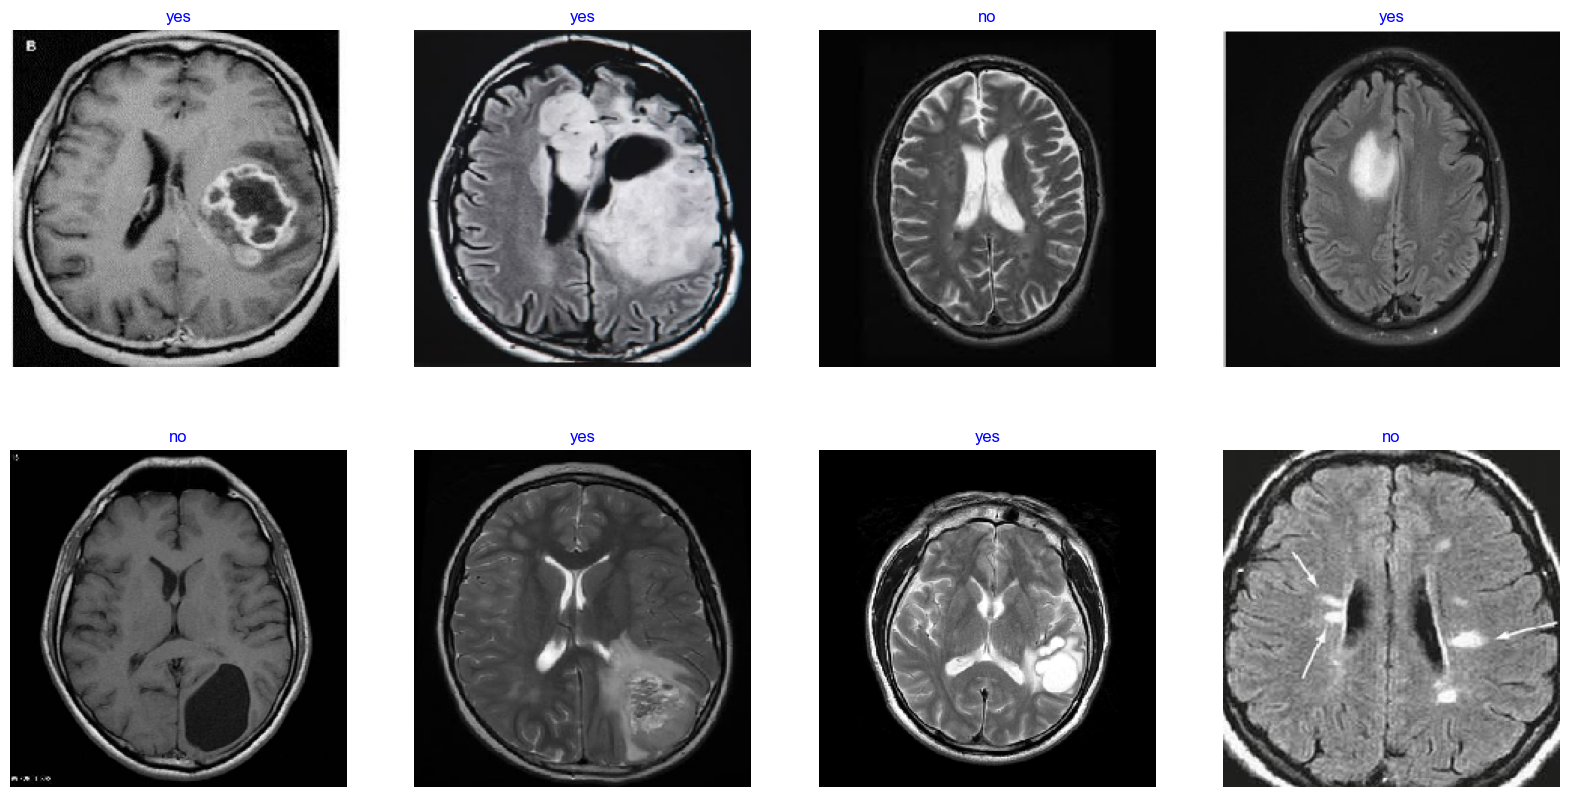

In [32]:
# Show sample from train data
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), classes names: string
images, labels = next(train_gen)  # get a batch size samples from the generator
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [34]:
# Define the image shape and number of classes
img_shape = (224, 224, 3)  # Example image shape
class_count = 2  # Example number of classes, adjust as needed

In [36]:

# Create pre-trained model (EfficientNetB3)
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 59s 1us/step


In [38]:
# Define the model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])


In [40]:
# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [48]:
# Train the model
epochs = 15  # Number of all epochs in training
history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=test_gen, validation_steps=None, shuffle=False)


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.6793 - loss: 13.6843 - val_accuracy: 0.7451 - val_loss: 20.0262
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.8269 - loss: 11.1880 - val_accuracy: 0.6863 - val_loss: 18.4975
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.7405 - loss: 9.0762 - val_accuracy: 0.8235 - val_loss: 12.0317
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.8353 - loss: 7.9007 - val_accuracy: 0.8627 - val_loss: 8.5030
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.7905 - loss: 7.0713 - val_accuracy: 0.9020 - val_loss: 7.4239
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.7570 - loss: 6.3940 - val_accuracy: 0.9020 - val_loss: 6.5736
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.8304 - loss: 6.1365 - val_accuracy: 0.7451 - val_loss: 6.4837
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.8014 - loss: 5.9851 - val_accuracy: 0.862

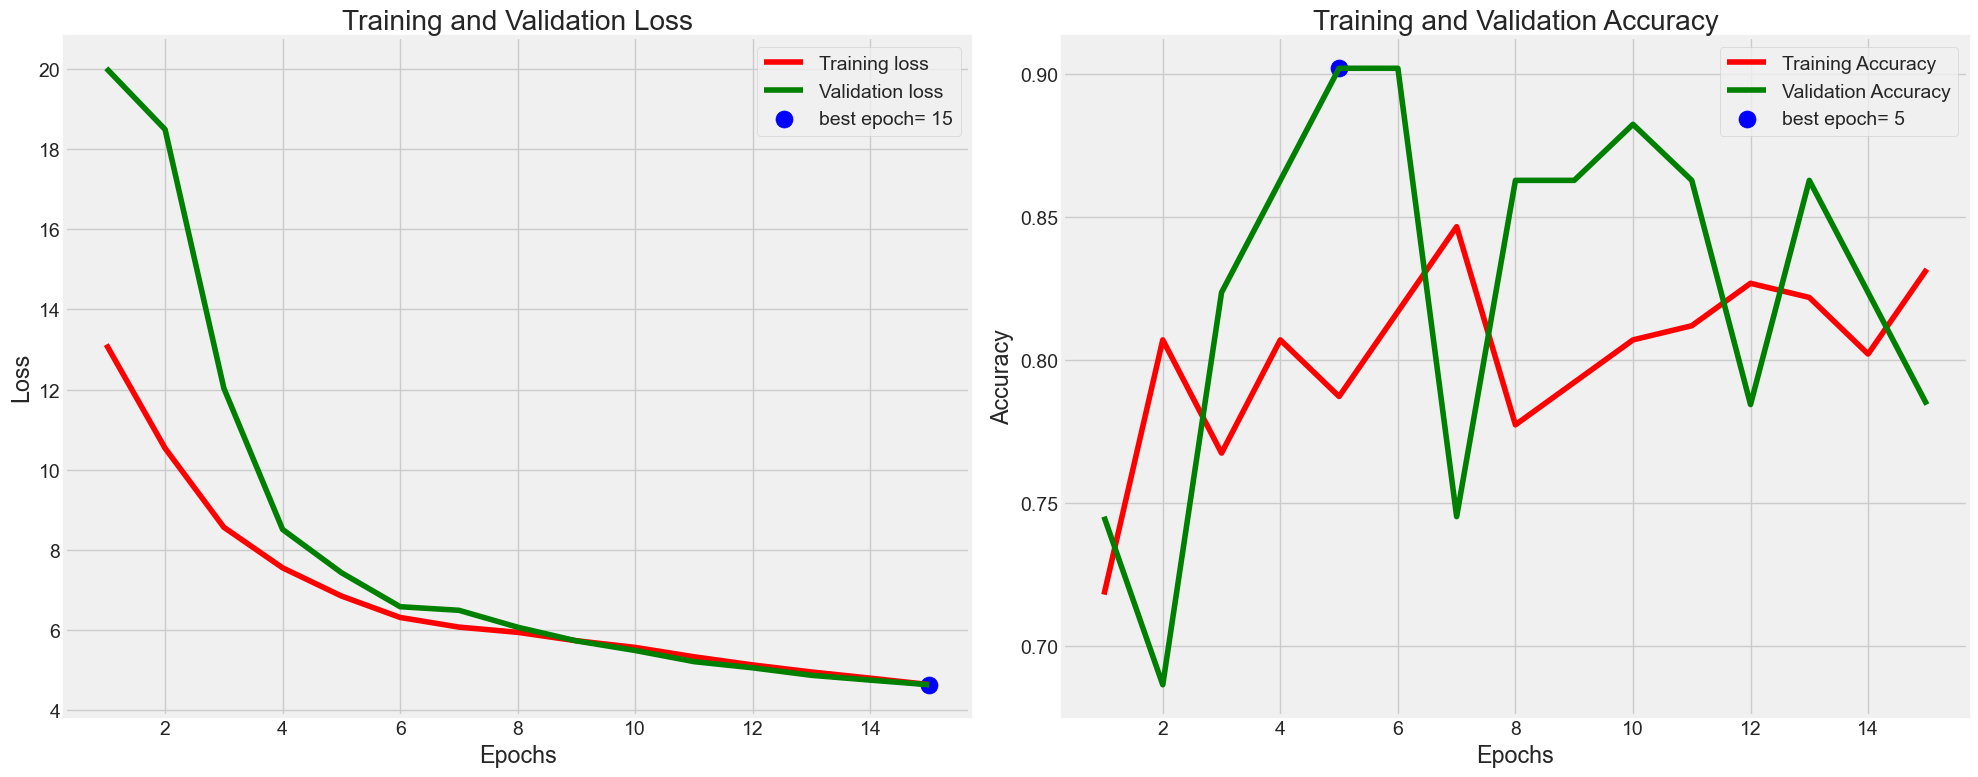

In [49]:

# Plot training history
Epochs = [i + 1 for i in range(epochs)]
tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_acc = np.argmax(val_acc)
index_loss = np.argmin(val_loss)
acc_highest = val_acc[index_acc]
val_lowest = val_loss[index_loss]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
# Evaluate model
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.8647 - loss: 4.5649
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 817ms/step - accuracy: 0.7760 - loss: 4.6584
Train Loss:  4.587747573852539
Train Accuracy:  0.8613861203193665
--------------------
Test Loss:  4.623385429382324
Test Accuracy:  0.7843137383460999


In [54]:
# Get Predictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step 


In [56]:
# Confusion Matrix and Classification Report
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

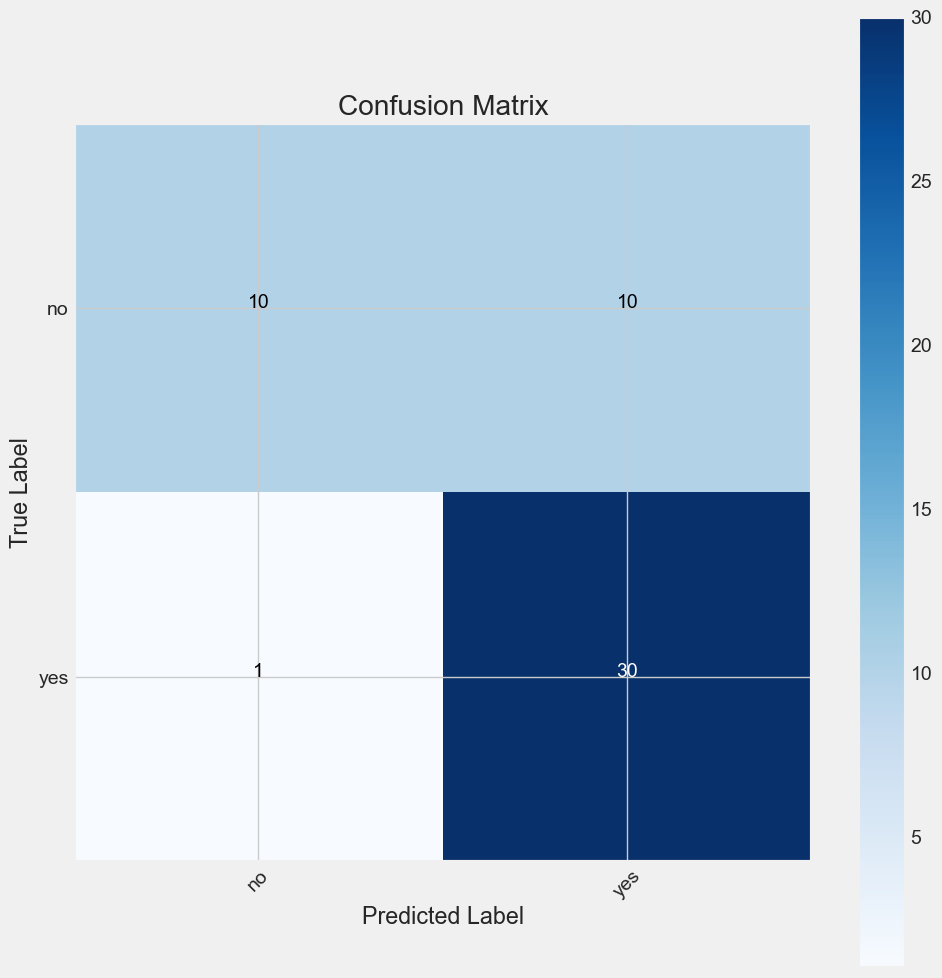

In [58]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [60]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

          no       0.91      0.50      0.65        20
         yes       0.75      0.97      0.85        31

    accuracy                           0.78        51
   macro avg       0.83      0.73      0.75        51
weighted avg       0.81      0.78      0.77        51



In [62]:
# Save the model
model.save('Models.h5')
print("Model saved")


Model saved
